In [1]:
from dae import DenoisingAE
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd


In [2]:
def open_ct_file(filepath,sep='\t', skiprows=0):
    return pd.read_csv(filepath, sep=sep, encoding='utf8', skiprows=skiprows)

counts_df = open_ct_file("/Users/timniemeijer/GTEx/DATA/41467_2017_BFncomms15824_MOESM390_ESM.txt")


In [3]:
#transpose
counts_df = counts_df.T

counts_df.head()

,DDX11L1,OR4F5,M37726,LOC643837,AK056486,SAMD11,KLHL17,PLEKHN1,ISG15,AGRN,...,STRF6,DQ584698,MTND5,cytochrome b,AF079515,DQ582201,JA760602,JA760600,JA760615,tRNA Pro
65937,10,0,0,626,5,317,80,7,45,557,...,0,0,0,0,706,18,37448,0,0,0
66623,17,0,0,525,7,126,106,34,128,1880,...,0,0,0,0,842,20,23645,0,0,0
69245,0,0,0,1268,44,1302,307,57,93,1363,...,0,0,0,0,1085,63,35142,0,0,0
69248,15,0,0,539,14,61,255,16,503,3554,...,0,0,0,0,2271,23,53165,0,0,0
69456,7,0,0,726,54,1163,175,41,87,862,...,0,0,0,0,2540,63,43857,0,0,0


In [4]:
def filter_counts(counts, median_cutoff=1, ocurrence_ratio=0.95):
   """
   Method for normalizing counts using counts per million (CPM)
   normalization with median cutoff and presence of expression in samples.
   """
   counts = counts.loc[:, (counts != 0).any(axis=0)].fillna(0)
   counts = counts.loc[:, (counts.median() > median_cutoff)]
   percentage_above_zero = (counts > 0).mean()
   return counts.loc[:, percentage_above_zero > ocurrence_ratio]

In [5]:
import numpy as np

def counts_to_cpm(counts):
    #samples in row, features in columns
    total_counts = np.array([counts.iloc[x,:].sum()/1e6 for x in range(counts.shape[0])])
    return (counts.T / total_counts).apply(np.ceil).T

def log2_counts(counts):
    return counts.apply(lambda x: np.log2(x + 1))

def center_counts(counts):
    meancounts = counts.mean()
    return counts - meancounts, meancounts

counts_df = filter_counts(counts_df)
counts_df = counts_to_cpm(counts_df)


In [6]:
import random

import numpy as np
import random

def prepare_counts(counts_df, noise_factor=10.0, outlier_fraction=0.05, seed=None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    ncounts_df = log2_counts(counts_df)
    ncounts_df, mean_counts = center_counts(ncounts_df)
    counts = ncounts_df.to_numpy()

    rows, cols = counts.shape
    num_outliers = int(outlier_fraction * counts.size)

    outlier_indices = np.random.choice(counts.size, num_outliers, replace=False)
    row_idx, col_idx = np.unravel_index(outlier_indices, counts.shape)

    noisy_counts = counts.copy()
    true_outlier_mask = np.zeros_like(counts, dtype=bool)

    # Add z-score based noise
    gene_std = counts.std(axis=0)
    noise = noise_factor * gene_std[col_idx] * np.random.choice([-1, 1], size=num_outliers)

    noisy_counts[row_idx, col_idx] += noise
    true_outlier_mask[row_idx, col_idx] = True

    return counts, noisy_counts, cols, true_outlier_mask, mean_counts

In [7]:
# autoencoder:
import torch.nn as nn

class DenoisingAE(nn.Module):

    def __init__(self, input_dim, encoding_dim=16, encoder_weights=None, decoder_weights=None):
        super(DenoisingAE, self).__init__()
        self.encoder = nn.Linear(input_dim, encoding_dim, bias=False)
        self.decoder = nn.Linear(encoding_dim, input_dim, bias=False)

        # Initialize weights with PCA components
        if encoder_weights is not None and decoder_weights is not None:
            with torch.no_grad():  # Prevents tracking gradients
                self.encoder.weight.copy_(torch.tensor(encoder_weights, dtype=torch.float32).T)
                self.decoder.weight.copy_(torch.tensor(decoder_weights, dtype=torch.float32).T)
                
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded) 
        return decoded


In [8]:
from sklearn.decomposition import PCA

def train_model(counts_df, encoding_dim, method=None, epochs=50, patience=10, learning_rate=1e-4):
    # Define model parameters
    counts, noisy_counts, input_dim, true_outliers, mean_counts = prepare_counts(counts_df)
    # Initialize model, loss function, and optimizer
    if method == 'pca':
        # Assume `data` is (samples x genes) = (119, 12975)
        pca = PCA(n_components=encoding_dim)  # Match encoding_dim
        pca.fit(counts)

        # Get PCA components (encoder weights)
        encoder_weights = pca.components_.T # (input_dim, encoding_dim)
        decoder_weights = pca.components_  # (encoding_dim, input_dim)
    else:
        encoder_weights = None
        decoder_weights = None

    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    model = DenoisingAE(input_dim, encoding_dim, encoder_weights, decoder_weights).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    clean_data = torch.Tensor(counts)  # Ground truth clean data
    loss_list = []
    early_stop_counter = 0
    best_loss = np.inf
    for epoch in range(epochs):
        counts, noisy_counts, input_dim, true_outliers, mean_counts = prepare_counts(counts_df)
        noisy_data = torch.Tensor(noisy_counts) # new noise every time
        # Convert to DataLoader
        dataset = TensorDataset(noisy_data, clean_data)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
        model.train()
        total_loss = 0
        for batch_noisy, batch_clean in dataloader:
            batch_noisy, batch_clean = batch_noisy.to(device), batch_clean.to(device)
            optimizer.zero_grad()
            outputs = model(batch_noisy)
            loss = criterion(outputs, batch_clean)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_list.append(total_loss/len(dataloader))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_list[-1]:.4f}")

        if loss.item() >= best_loss:
            early_stop_counter += 1
        else:
            early_stop_counter = 0
            best_loss = loss.item()
            torch.save(model.state_dict(), "checkpoint.pth")
            
        if early_stop_counter >= patience:
            break
        
    return model, loss_list




In [9]:
import warnings

import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as ss 
import seaborn as sns
from statsmodels.stats.multitest import multipletests



warnings.filterwarnings('ignore')

def get_nb_or_pois_val(s):
    X = np.ones_like(s) # counts
    mu = np.mean(s)
    sigma_sqr = np.var(s)
    if sigma_sqr >= mu:
        res = sm.NegativeBinomial(s,X).fit(start_params=[1,1], disp=0)
        mu = np.exp(res.params[0])
        p = 1/(1+mu*res.params[1])
        n = mu*p/(1-p)
        return "NB", mu, p, n
    else:
        # Poisson: If variance is not greater than mean, fall back to Poisson
        lambda_poisson = mu  # For Poisson, lambda = mu
        return "P", lambda_poisson

def two_tailed(pmf_values):
    return 2 * np.minimum(pmf_values, 1 - pmf_values)

def get_nb_or_pois_pvals(s):
    res = get_nb_or_pois_val(s)
    if res[0] == "NB":
        type_dist, mu, p, n = res
        pmf_values = ss.nbinom.pmf(s,n,p)
        return two_tailed(pmf_values)  # Two-tailed p-values
    else:
        type_dist, lambda_poisson = res
        pmf_values = ss.poisson.pmf(s,lambda_poisson)
        return two_tailed(pmf_values)  # Two-tailed p-values


def get_pvalue_from_df(counts_df):
    
    # Fit data to NB and get probabilities
    p_value_df = counts_df.apply(func=lambda x: get_nb_or_pois_pvals((x)))

    # Flatten the p-values into a single array
    pvals = p_value_df.values.flatten()
    # Apply FDR correction using B-Y procedure
    # The result from multipletests is a tuple; we need the corrected p-values (last element of the tuple)
    reject, pvals_corrected, _, _ = multipletests(pvals, method='fdr_by')

    significant_map = np.array([True if x < 0.05 else False for x in pvals_corrected])

    # Reshape the corrected p-values back into the original shape of the DataFrame
    padj_df = pd.DataFrame(pvals_corrected.reshape(counts_df.shape), columns=counts_df.columns, index=counts_df.index)

    return p_value_df, padj_df, significant_map


In [10]:
def get_normalized_counts(model, counts_df):
    ncounts_df = log2_counts(counts_df)
    ncounts_df, mean_counts = center_counts(ncounts_df)
    counts = ncounts_df.to_numpy()
    clean_data = torch.Tensor(counts)
    model.to('cpu')
    autoencoded_data = model(clean_data)
    autoencoded_data = autoencoded_data.detach().numpy()
    autoenc_counts_df = pd.DataFrame(
                    autoencoded_data,
                    index=counts_df.index,
                    columns=counts_df.columns)
    # The autoencoded counts are the new means (expected counts
    # Autoencoded means back to the same scale by adding the previously substracted (log2) mean counts to them 
    new_mean_counts_df = ((autoenc_counts_df + mean_counts).apply(np.exp2) - 1)

    return (counts_df + (new_mean_counts_df - counts_df.mean())).clip(0.01).round()

In [11]:
from sklearn.metrics import roc_auc_score
import time

def evaluate_model(model, counts_df, device="cpu"):
    model.eval()
    #smaller fraction of outliers, to simulate real life scenarios
    counts, noisy_counts, cols, outlier_mask, mean_counts = prepare_counts(counts_df, noise_factor=6, outlier_fraction=0.001, seed=42)
    noisy_counts_df = pd.DataFrame(
                    noisy_counts,
                    index=counts_df.index,
                    columns=counts_df.columns)
    noisy_counts_df = ((noisy_counts_df + mean_counts).apply(np.exp2) - 1)
    noisy_counts_df = noisy_counts_df.clip(0.01).round()
    norm_counts = get_normalized_counts(model, noisy_counts_df)
    
    pval_df, padj_df, significant = get_pvalue_from_df(norm_counts)

    # Flatten everything for AUC
    y_true = outlier_mask.flatten().astype(int)

    auc = roc_auc_score(y_true, significant)
    return auc

encoding_dims = [1, 2, 4, 6]
auc_dict = {}

for dim in encoding_dims:
    print(f"encoding dim: {dim}")
    start_time = time.time()
    
    model, loss_list = train_model(counts_df, dim, epochs=50, method='pca')
    #load best pretrained model
    model.load_state_dict(torch.load("checkpoint.pth"))
    auc = evaluate_model(model, counts_df)
    elapsed_time = time.time() - start_time
    print(f"Encoding dim: {dim}, AUC: {auc:.4f}, elapsed time: {elapsed_time:.2f} sec")
    auc_dict.update({dim:auc})

encoding dim: 1
Epoch 1/50, Loss: 0.1882
Epoch 2/50, Loss: 0.1839
Epoch 3/50, Loss: 0.1865
Epoch 4/50, Loss: 0.1853
Epoch 5/50, Loss: 0.1846
Epoch 6/50, Loss: 0.1834
Epoch 7/50, Loss: 0.1872
Epoch 8/50, Loss: 0.1892
Epoch 9/50, Loss: 0.1849
Epoch 10/50, Loss: 0.1822
Epoch 11/50, Loss: 0.1887
Epoch 12/50, Loss: 0.1839
Epoch 13/50, Loss: 0.1874
Epoch 14/50, Loss: 0.1897
Epoch 15/50, Loss: 0.1825
Epoch 16/50, Loss: 0.1913
Epoch 17/50, Loss: 0.1825
Epoch 18/50, Loss: 0.1873
Epoch 19/50, Loss: 0.1821
Epoch 20/50, Loss: 0.1824
Epoch 21/50, Loss: 0.1833
Epoch 22/50, Loss: 0.1851
Epoch 23/50, Loss: 0.1870
Epoch 24/50, Loss: 0.1855
Epoch 25/50, Loss: 0.1830
Epoch 26/50, Loss: 0.1886
Epoch 27/50, Loss: 0.1872
Epoch 28/50, Loss: 0.1883
Epoch 29/50, Loss: 0.1898
Encoding dim: 1, AUC: 0.6719, elapsed time: 47.57 sec
encoding dim: 2
Epoch 1/50, Loss: 0.1665
Epoch 2/50, Loss: 0.1664
Epoch 3/50, Loss: 0.1692
Epoch 4/50, Loss: 0.1667
Epoch 5/50, Loss: 0.1644
Epoch 6/50, Loss: 0.1663
Epoch 7/50, Loss: 0

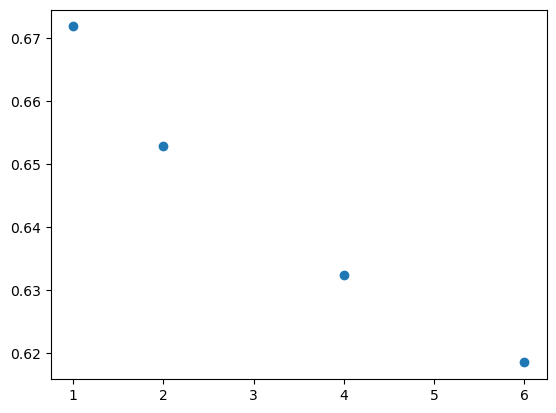

In [12]:
import matplotlib.pyplot as plt

plt.scatter(x=auc_dict.keys(), y=auc_dict.values())

In [13]:

import numpy as np

enc_dim = max(auc_dict, key=auc_dict.get)

model, loss_list = train_model(counts_df, enc_dim, epochs=50, method='pca')

#load best pretrained model
model.load_state_dict(torch.load("checkpoint.pth"))

Epoch 1/50, Loss: 0.1835
Epoch 2/50, Loss: 0.1868
Epoch 3/50, Loss: 0.1830
Epoch 4/50, Loss: 0.1856
Epoch 5/50, Loss: 0.1878
Epoch 6/50, Loss: 0.1877
Epoch 7/50, Loss: 0.1887
Epoch 8/50, Loss: 0.1870
Epoch 9/50, Loss: 0.1875
Epoch 10/50, Loss: 0.1848
Epoch 11/50, Loss: 0.1838
Epoch 12/50, Loss: 0.1923
Epoch 13/50, Loss: 0.1893


<All keys matched successfully>

In [14]:
norm_counts_df = get_normalized_counts(model, counts_df)

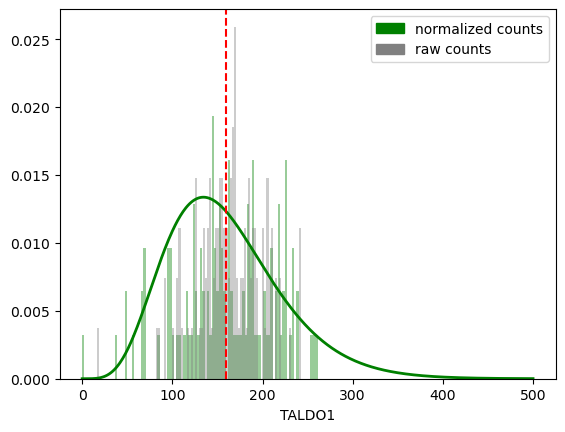

In [28]:
import matplotlib.patches as mpatches 

data = norm_counts_df.iloc[:,:]["TALDO1"]
data_raw = counts_df.iloc[:,:]["TALDO1"]
x_plot = np.linspace(0,500,501)
res = get_nb_or_pois_val(data)

if res[0] == "NB":
    type_dist, mu, p, n = res
    pmf_values = ss.nbinom.pmf(x_plot,n,p)
    y_vals = two_tailed(pmf_values)  # Two-tailed p-values
else:
    type_dist, lambda_poisson = res
    pmf_values = ss.poisson.pmf(x_plot,lambda_poisson)
    y_vals = two_tailed(pmf_values)  # Two-tailed p-values

ax = sns.distplot(data, kde=False, norm_hist=True, bins=100, color='green')
ax = sns.distplot(data_raw, kde=False, norm_hist=True, bins=100, color='grey')
green_patch = mpatches.Patch(color='green', label='normalized counts')
grey_patch = mpatches.Patch(color='grey', label='raw counts')

# Show the legend with both line + patch handles
ax.legend(handles=[green_patch, grey_patch], loc='upper right')
ax.plot(x_plot, y_vals, 'g-', lw=2)
ax.axvline(x=mu, color='red', ls='--')
plt.show()

In [16]:
from statsmodels.stats.multitest import multipletests

# Fit data to NB and get probabilities

p_value_df = norm_counts_df.apply(func=lambda x: get_nb_or_pois_pvals((x)))


# Flatten the p-values into a single array
pvals = p_value_df.values.flatten()

# Apply FDR correction using B-Y procedure
# The result from multipletests is a tuple; we need the corrected p-values (last element of the tuple)
reject, pvals_corrected, _, _ = multipletests(pvals, method='fdr_by')

# Reshape the corrected p-values back into the original shape of the DataFrame
p_adj_df = pd.DataFrame(pvals_corrected.reshape(norm_counts_df.shape), columns=norm_counts_df.columns, index=norm_counts_df.index)

In [17]:
# calculate zscores based on log2 counts
df_log2 = norm_counts_df.apply(lambda x: np.log2(x + 1))
z_score_df = (df_log2 - df_log2.mean())/df_log2.std(ddof=0)

In [18]:
# create patient/effect dataframe

df_list = []
for patient_index in norm_counts_df.index:
    pat_df = pd.DataFrame({"patient":[patient_index for x in range(len(norm_counts_df.T.index))], "gene":norm_counts_df.T.index, "padj":p_adj_df.T[patient_index], "pValue":p_value_df.T[patient_index].values, "zScore":z_score_df.T[patient_index].values,"RawCounts(CPM)":counts_df.T[patient_index] , "corrected_counts(CPM)":norm_counts_df.T[patient_index], "meanCounts(CPM)":norm_counts_df.mean().T}).reset_index()
    df_list.append(pat_df)

patients_df = pd.concat(df_list)

In [26]:
patient = "MUC1410"
res = patients_df[patients_df["padj"] < 0.05]

res[res["patient"] == patient].sort_values("padj", ascending=True)


,index,patient,gene,padj,pValue,zScore,RawCounts(CPM),corrected_counts(CPM),meanCounts(CPM)
6663,TALDO1,MUC1410,TALDO1,0.000319,1.481916e-09,-8.410794,16.0,0.0,159.588235


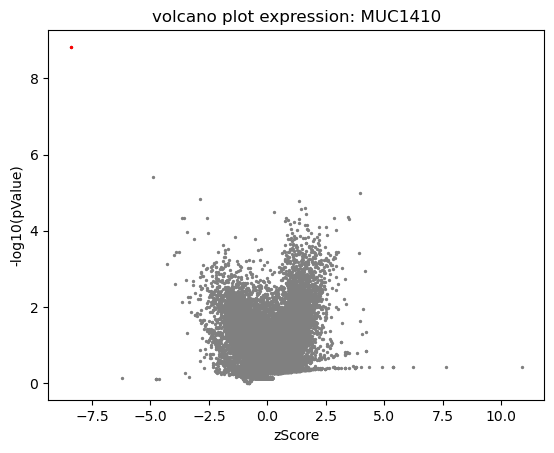

In [27]:
def negative_log10(x):
    return -np.log10(x)

plt.scatter(patients_df["zScore"][patients_df["patient"] == patient],negative_log10(patients_df["pValue"][patients_df["patient"] == patient]), s=2, color='grey')
plt.scatter(res["zScore"][res["patient"] == patient],negative_log10(res["pValue"][res["patient"] == patient]), s=2, color='red')

plt.xlabel("zScore")
plt.ylabel("-log10(pValue)")
plt.title(f'volcano plot expression: {patient}')

plt.show()

In [21]:
abberant_pt_dict = {pt:len(res[res["patient"] == pt]) for pt in counts_df.index.unique()}
sorted_pt_abberant = dict(sorted(abberant_pt_dict.items(), key=lambda x: x[1]))

In [22]:
# compare with kremer dataset
positive_calls = pd.read_csv("/Users/timniemeijer/GTEx/DATA/positive_control_calls.txt", sep='\t')
metadata = pd.read_csv("/Users/timniemeijer/GTEx/DATA/metadata_kremer.txt", sep='\t')

In [23]:
positive_calls =positive_calls.astype({"FIBROBLAST_ID":str})

metadata["expression_outliers_original"] = [positive_calls[positive_calls["FIBROBLAST_ID"] == row]["NUM_RNA_ABER_EXP_SIGNI"].values for row in metadata["FIBROBLAST_ID"].values]
metadata["expression_outliers_original"] = [v[0] if v else 0 for v in metadata["expression_outliers_original"] ]
metadata["expression_outliers_ours"] = [sorted_pt_abberant[row] if row in sorted_pt_abberant.keys() else 0 for row in metadata["RNA_ID"].values]
metadata['rna_effect'] = [positive_calls[positive_calls["FIBROBLAST_ID"] == row]["RNA_DEFECT_FOR_DIAGNOSIS_GENE"].values for row in metadata["FIBROBLAST_ID"].values]
metadata['rna_effect'] = [v[0] if v else '' for v in metadata["rna_effect"] ]
metadata['disease_gene'] = [positive_calls[positive_calls["FIBROBLAST_ID"] == row]["DIAGNOSIS_GENE"].values for row in metadata["FIBROBLAST_ID"].values]
metadata['disease_gene'] = [v[0] if v else '' for v in metadata["disease_gene"] ]
metadata["found_outlier_result"] = [row[1] in res[res['patient'] == row[0]]["gene"].values for row in metadata[["RNA_ID","disease_gene"]].values]

Text(0, 0.5, '#outlier genes')

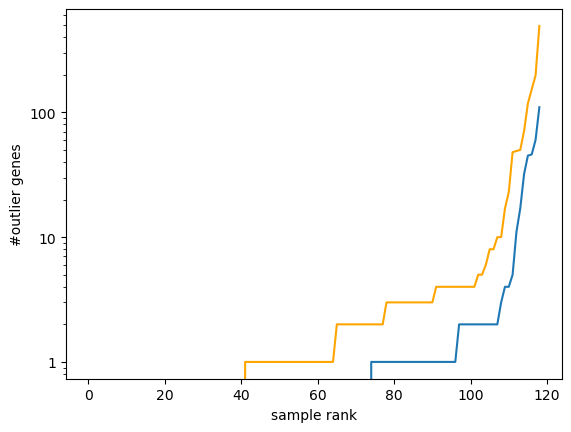

In [24]:


plt.plot(sorted_pt_abberant.values())
plt.plot(metadata.sort_values("expression_outliers_original")["expression_outliers_original"].values, c='orange')
plt.yscale('log')
plt.yticks([1,10,100],labels=[1,10,100])
plt.xlabel('sample rank')
plt.ylabel('#outlier genes')

In [25]:
metadata[metadata['found_outlier_result']] 

,FIBROBLAST_ID,RNA_ID,SEX,RNA_HOX_GROUP,RNA_BATCH_GROUP,expression_outliers_original,expression_outliers_ours,rna_effect,disease_gene,found_outlier_result
2,61695,61695,male,magenta,orange,48,1,aberrant_expression,DNAJC3,True
30,61691,76636,male,magenta,darkgreen,4,2,aberrant_expression,DNAJC3,True
85,73804,MUC1396,male,magenta,darkgreen,6,4,aberrant_expression,MGST1,True
97,83331,MUC1410,male,magenta,orange,1,1,NaN,TALDO1,True
